In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

2025-04-20 10:38:08.631892: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745145488.818113      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745145488.872546      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import VGG16, InceptionV3, MobileNetV2, DenseNet121
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [4]:
image_size = (224, 224)

train_dir = '/kaggle/input/plantdisease/PlantVillage'

data_generator = ImageDataGenerator(rescale=1.0/255.0,validation_split = 0.2)

train_data = data_generator.flow_from_directory(train_dir,target_size=image_size,batch_size=32,class_mode='categorical',subset='training',shuffle=True)

val_data = data_generator.flow_from_directory(train_dir,target_size=image_size,batch_size=32,class_mode='categorical',subset='validation',shuffle=True)


Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.


In [5]:
class_name = list(train_data.class_indices.keys())
print(class_name)

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [6]:
#using MobileNetV2
base_model_mobileNet=MobileNetV2(weights="imagenet", include_top = False, input_shape=(224,224,3))
base_model_mobileNet.trainable = False

I0000 00:00:1745145507.053614      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
model_mobileNet = Sequential([
    base_model_mobileNet,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'), # Add a Dense layer
    Dropout(0.5), # Add a dropout layer
    Dense(len(train_data.class_indices), activation='softmax') # Output layer
])

In [8]:
model_mobileNet.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,921,551 (11.14 MB)

 Trainable params: 663,567 (2.53 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
model_mobileNet.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [10]:
#define callbacks

callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


In [11]:
#train the model
history = model_mobileNet.fit(
    train_data,
    epochs=100,
    validation_data=val_data,
    callbacks=[callback]
)

Epoch 1/100


I0000 00:00:1745145518.932814      71 service.cc:148] XLA service 0x7c335c10fd40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745145518.933694      71 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745145519.769158      71 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/517 ━━━━━━━━━━━━━━━━━━━━ 1:47:48 13s/step - accuracy: 0.0312 - loss: 3.3124

I0000 00:00:1745145523.695374      71 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


517/517 ━━━━━━━━━━━━━━━━━━━━ 115s 199ms/step - accuracy: 0.6714 - loss: 1.0556 - val_accuracy: 0.8799 - val_loss: 0.3653
Epoch 2/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 41s 78ms/step - accuracy: 0.8596 - loss: 0.4147 - val_accuracy: 0.8964 - val_loss: 0.3007
Epoch 3/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 43s 81ms/step - accuracy: 0.8905 - loss: 0.3273 - val_accuracy: 0.9093 - val_loss: 0.2704
Epoch 4/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 39s 75ms/step - accuracy: 0.9029 - loss: 0.2879 - val_accuracy: 0.9107 - val_loss: 0.2492
Epoch 5/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - accuracy: 0.9096 - loss: 0.2622 - val_accuracy: 0.9202 - val_loss: 0.2315
Epoch 6/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 43s 82ms/step - accuracy: 0.9213 - loss: 0.2322 - val_accuracy: 0.9187 - val_loss: 0.2447
Epoch 7/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 40s 76ms/step - accuracy: 0.9263 - loss: 0.2058 - val_accuracy: 0.9296 - val_loss: 0.2082
Epoch 8/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 40s 77ms/step - accuracy: 0.9346 - loss: 0.1839 - va

In [12]:
print('Model accuracy:',history.history['accuracy'])

Model accuracy: [0.7707677483558655, 0.8617098331451416, 0.8906514644622803, 0.9028214812278748, 0.9069992899894714, 0.9205618500709534, 0.9256478548049927, 0.9318236708641052, 0.9340639114379883, 0.9419956207275391, 0.9430249333381653, 0.9419956207275391, 0.9437515139579773, 0.9504117369651794, 0.9515015482902527, 0.9559215307235718]


In [13]:
model_mobileNet.save("mobilenetAICropPrediction.h5")

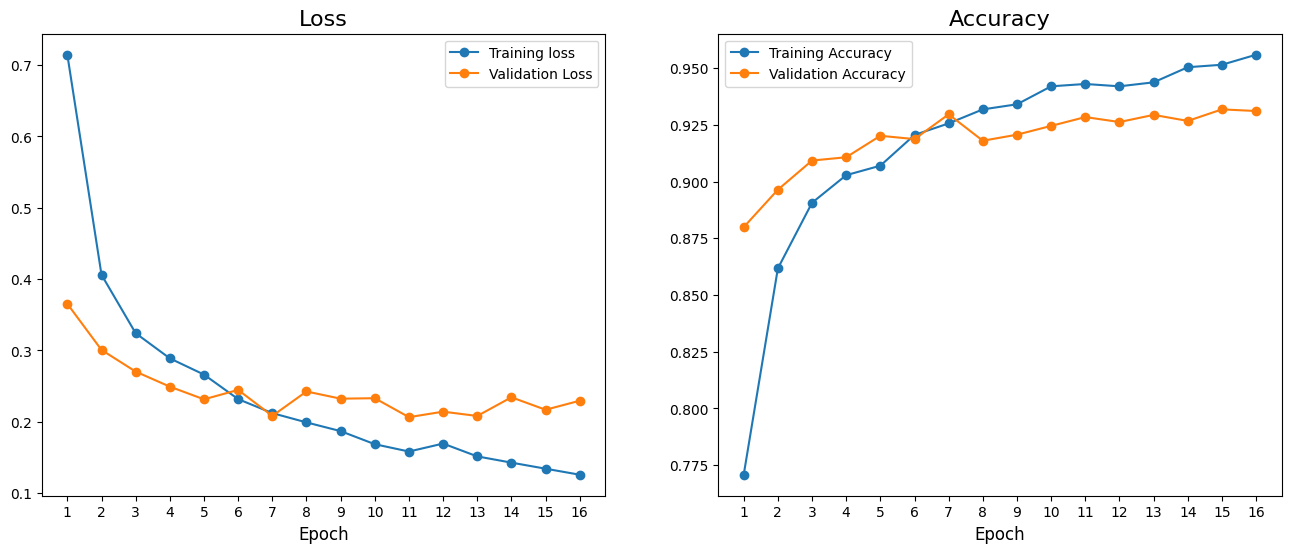

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
title_fontsize = 16
axis_fontsize = 12

total_epochs = len(history.history['accuracy'])

ax1.plot(range(1, total_epochs + 1), history.history['loss'], marker='o', label='Training loss')
ax1.plot(range(1, total_epochs + 1), history.history['val_loss'], marker='o', label='Validation Loss')
ax1.legend()
ax1.set_xticks(range(1, total_epochs + 1))
ax1.set_title('Loss', fontsize=title_fontsize)
ax1.set_xlabel('Epoch', fontsize=axis_fontsize)

ax2.plot(range(1, total_epochs + 1), history.history['accuracy'], marker='o', label='Training Accuracy')
ax2.plot(range(1, total_epochs + 1), history.history['val_accuracy'], marker='o', label='Validation Accuracy')
ax2.legend()
ax2.set_xticks(range(1, total_epochs + 1))
ax2.set_title('Accuracy', fontsize=title_fontsize)
ax2.set_xlabel('Epoch', fontsize=axis_fontsize);

In [15]:
#predict classes for 1000 images
y_true = []
y_pred = []
limit=1000
for image, labels in val_data:
    y_true.extend(np.argmax(labels, axis = 1))
    preds = model_mobileNet.predict(image)
    y_pred.extend(np.argmax(preds, axis=1))
    limit-=1
    if limit==0:
        break

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━

In [16]:
accuracy = accuracy_score(y_true, y_pred)
precision= precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
classification = classification_report(y_true, y_pred, target_names = class_name)
print(f"precision:{precision}")
print(f"recall:{recall}")
print(f"accuracy:{accuracy}")
print(f"classification:{classification}")

precision:0.9293588201424638
recall:0.9284999061267915
accuracy:0.9284999061267915
classification:                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.94      0.99      0.96      1545
                     Pepper__bell___healthy       0.99      0.97      0.98      2303
                      Potato___Early_blight       0.97      0.98      0.97      1537
                       Potato___Late_blight       0.95      0.95      0.95      1549
                           Potato___healthy       0.79      0.90      0.84       230
                      Tomato_Bacterial_spot       0.95      0.94      0.95      3279
                        Tomato_Early_blight       0.86      0.68      0.76      1563
                         Tomato_Late_blight       0.92      0.93      0.93      2954
                           Tomato_Leaf_Mold       0.89      0.94      0.91      1465
                  Tomato_Septoria_leaf_spot       0

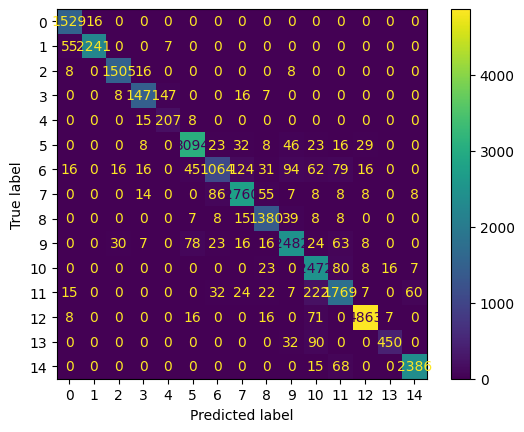

In [17]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_true, y_pred)

metrics.ConfusionMatrixDisplay(confusion_matrix).plot()

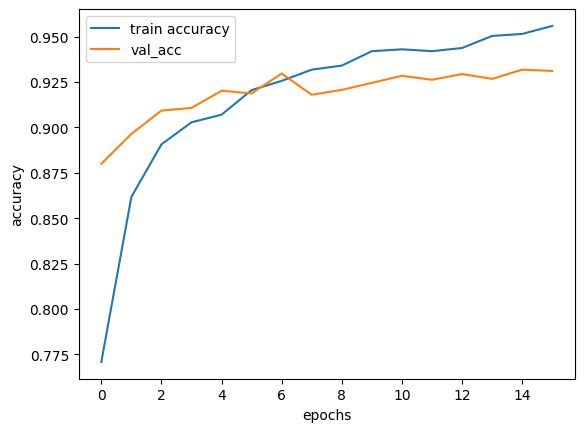

In [18]:
plt.plot(history.history["accuracy"], label="train accuracy")
plt.plot(history.history['val_accuracy'], label = "val_acc")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [19]:
#creating a model with more hidden layers

model_mobileNet_2 = Sequential([
    base_model_mobileNet,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'), # Add a Dense layer
    Dropout(0.5), # Add a dropout layer
    BatchNormalization(),
    Dense(256, activation = 'relu'),# Add a Dense layer
    Dropout(0.5), # Add a dropout layer
    BatchNormalization(),
    Dense(128, activation = 'relu'),# Add a Dense layer
    Dropout(0.5), # Add a dropout layer
    Dense(len(train_data.class_indices), activation='softmax') # Output layer
])

In [20]:
model_mobileNet_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,083,087 (11.76 MB)

 Trainable params: 823,567 (3.14 MB)

 Non-trainable params: 2,259,520 (8.62 MB)

In [21]:
model_mobileNet_2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [22]:
callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


In [23]:
#train the model
history2 = model_mobileNet_2.fit(
    train_data,
    epochs=100,
    validation_data=val_data,
    callbacks=[callback]
)

Epoch 1/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 62s 95ms/step - accuracy: 0.3694 - loss: 2.0915 - val_accuracy: 0.7906 - val_loss: 0.6316
Epoch 2/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 39s 76ms/step - accuracy: 0.6616 - loss: 1.0542 - val_accuracy: 0.8137 - val_loss: 0.5521
Epoch 3/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 39s 74ms/step - accuracy: 0.7083 - loss: 0.9020 - val_accuracy: 0.8462 - val_loss: 0.4611
Epoch 4/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 38s 73ms/step - accuracy: 0.7357 - loss: 0.8227 - val_accuracy: 0.8668 - val_loss: 0.4016
Epoch 5/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 39s 74ms/step - accuracy: 0.7499 - loss: 0.7954 - val_accuracy: 0.8702 - val_loss: 0.3990
Epoch 6/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 38s 73ms/step - accuracy: 0.7508 - loss: 0.7711 - val_accuracy: 0.8523 - val_loss: 0.4590
Epoch 7/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 38s 72ms/step - accuracy: 0.7468 - loss: 0.7991 - val_accuracy: 0.8777 - val_loss: 0.3954
Epoch 8/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 40s 76ms/step - accuracy: 0.7487 - loss: 0

In [24]:
model_mobileNet_2.save("mobilenetAICropPrediction_version2.h5")

In [25]:
#Using DenseNet

base_model = DenseNet121(weights="imagenet", include_top = False, input_shape=(224,224,3))
base_model.trainable = False
                         

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [26]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation = 'relu'))

model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation = 'relu'))

model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation = 'relu'))

model.add(Dropout(0.5))
model.add(Dense(15, activation = 'softmax'))

In [27]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 15)                  │             975 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,343,567 (28.01 MB)

 Trainable params: 305,295 (1.16 MB)

 Non-trainable params: 7,038,272 (26.85 MB)

In [28]:
callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [29]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history3 = model.fit(train_data, epochs= 100, validation_data = val_data, callbacks = [callback])

Epoch 1/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 108s 144ms/step - accuracy: 0.3330 - loss: 2.3658 - val_accuracy: 0.8171 - val_loss: 0.5578
Epoch 2/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 40s 77ms/step - accuracy: 0.6825 - loss: 0.9626 - val_accuracy: 0.8755 - val_loss: 0.3965
Epoch 3/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 42s 81ms/step - accuracy: 0.7570 - loss: 0.7412 - val_accuracy: 0.8981 - val_loss: 0.3140
Epoch 4/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 44s 84ms/step - accuracy: 0.7908 - loss: 0.6377 - val_accuracy: 0.8925 - val_loss: 0.3156
Epoch 5/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 46s 88ms/step - accuracy: 0.8196 - loss: 0.5729 - val_accuracy: 0.9102 - val_loss: 0.2675
Epoch 6/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 47s 90ms/step - accuracy: 0.8338 - loss: 0.5370 - val_accuracy: 0.9255 - val_loss: 0.2257
Epoch 7/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 45s 86ms/step - accuracy: 0.8419 - loss: 0.4988 - val_accuracy: 0.9185 - val_loss: 0.2341
Epoch 8/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 45s 86ms/step - accuracy: 0.8461 - loss:

In [30]:
model.save("densenetAICropPrediction.h5")

In [31]:
#removing some layers
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation = 'relu'))

model.add(Dropout(0.5))
model.add(Dense(15, activation = 'softmax'))

In [32]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,569,999 (28.88 MB)

 Trainable params: 532,495 (2.03 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [33]:
callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [34]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history4 = model.fit(train_data, epochs= 100, validation_data = val_data, callbacks = [callback])

Epoch 1/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 93s 129ms/step - accuracy: 0.6162 - loss: 1.2342 - val_accuracy: 0.8828 - val_loss: 0.3649
Epoch 2/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 42s 80ms/step - accuracy: 0.8550 - loss: 0.4278 - val_accuracy: 0.9073 - val_loss: 0.2879
Epoch 3/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - accuracy: 0.8842 - loss: 0.3427 - val_accuracy: 0.9190 - val_loss: 0.2476
Epoch 4/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 41s 78ms/step - accuracy: 0.9004 - loss: 0.2941 - val_accuracy: 0.9236 - val_loss: 0.2250
Epoch 5/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - accuracy: 0.9071 - loss: 0.2764 - val_accuracy: 0.9197 - val_loss: 0.2311
Epoch 6/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 41s 78ms/step - accuracy: 0.9143 - loss: 0.2505 - val_accuracy: 0.9326 - val_loss: 0.1975
Epoch 7/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 41s 78ms/step - accuracy: 0.9180 - loss: 0.2347 - val_accuracy: 0.9340 - val_loss: 0.1850
Epoch 8/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - accuracy: 0.9308 - loss: 

In [35]:
model.save("densenetAICropPrediction_ver2.h5")

In [36]:
#predict classes for 1000 images
y_true = []
y_pred = []
limit=1000
for image, labels in val_data:
    y_true.extend(np.argmax(labels, axis = 1))
    preds = model.predict(image)
    y_pred.extend(np.argmax(preds, axis=1))
    limit-=1
    if limit==0:
        break

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

In [37]:
accuracy = accuracy_score(y_true, y_pred)
precision= precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
classification = classification_report(y_true, y_pred, target_names = class_name)
print(f"precision:{precision}")
print(f"recall:{recall}")
print(f"accuracy:{accuracy}")
print(f"classification:{classification}")

precision:0.9562693087059363
recall:0.9558087130696044
accuracy:0.9558087130696044
classification:                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       1.00      0.97      0.98      1545
                     Pepper__bell___healthy       0.98      0.99      0.99      2285
                      Potato___Early_blight       0.99      0.99      0.99      1546
                       Potato___Late_blight       0.96      0.96      0.96      1539
                           Potato___healthy       0.85      0.97      0.90       230
                      Tomato_Bacterial_spot       0.98      0.98      0.98      3295
                        Tomato_Early_blight       0.90      0.83      0.86      1546
                         Tomato_Late_blight       0.96      0.94      0.95      2961
                           Tomato_Leaf_Mold       0.96      0.93      0.94      1467
                  Tomato_Septoria_leaf_spot       0

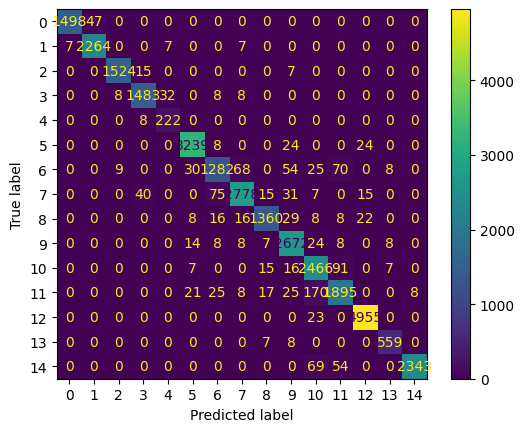

In [38]:
confusion_matrix = metrics.confusion_matrix(y_true, y_pred)

metrics.ConfusionMatrixDisplay(confusion_matrix).plot()

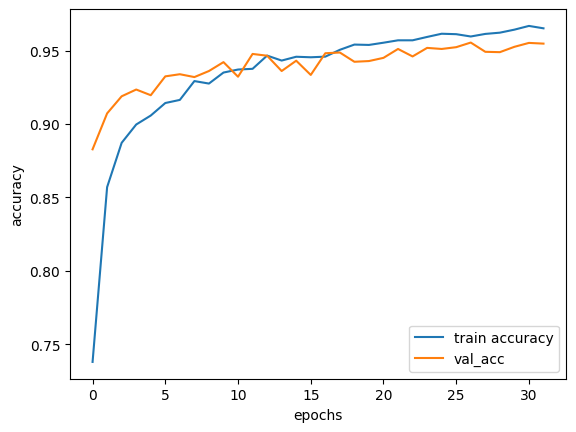

In [39]:
plt.plot(history4.history["accuracy"], label="train accuracy")
plt.plot(history4.history['val_accuracy'], label = "val_acc")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [40]:
#Using VGG16
base_model_2 = VGG16(weights="imagenet", include_top = False, input_shape=(224,224,3))
base_model_2.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [41]:
model = Sequential()
model.add(base_model_2)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation = 'relu'))

model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation = 'relu'))

model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation = 'relu'))

model.add(Dropout(0.5))
model.add(Dense(15, activation = 'softmax'))

In [42]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 15)                  │             975 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,889,679 (56.80 MB)

 Trainable params: 174,223 (680.56 KB)

 Non-trainable params: 14,715,456 (56.14 MB)

In [43]:
callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [44]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history5 = model.fit(train_data, epochs= 100, validation_data = val_data, callbacks = [callback])

Epoch 1/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 72s 114ms/step - accuracy: 0.3150 - loss: 2.5343 - val_accuracy: 0.6579 - val_loss: 1.0688
Epoch 2/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 48s 92ms/step - accuracy: 0.6021 - loss: 1.2247 - val_accuracy: 0.7977 - val_loss: 0.5952
Epoch 3/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 48s 92ms/step - accuracy: 0.7010 - loss: 0.9358 - val_accuracy: 0.8059 - val_loss: 0.5732
Epoch 4/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 48s 92ms/step - accuracy: 0.7193 - loss: 0.8517 - val_accuracy: 0.8246 - val_loss: 0.5362
Epoch 5/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 48s 92ms/step - accuracy: 0.7406 - loss: 0.8019 - val_accuracy: 0.8164 - val_loss: 0.5090
Epoch 6/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 48s 91ms/step - accuracy: 0.7651 - loss: 0.7281 - val_accuracy: 0.7627 - val_loss: 0.6669
Epoch 7/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 48s 92ms/step - accuracy: 0.7660 - loss: 0.7226 - val_accuracy: 0.8540 - val_loss: 0.4275
Epoch 8/100
517/517 ━━━━━━━━━━━━━━━━━━━━ 48s 92ms/step - accuracy: 0.7856 - loss: 

In [45]:
model.save("vgg16_AICropPrediction.h5")